# K均值聚类

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, threshold=16)
%matplotlib inline

## 机器学习实战

In [4]:
data = np.loadtxt('testSet.txt')
data

array([[ 1.659 ,  4.2851],
       [-3.4537,  3.4243],
       [ 4.8381, -1.1515],
       ...,
       [-2.9676,  2.8487],
       [ 4.4793, -1.7648],
       [-4.9056, -2.9111]])

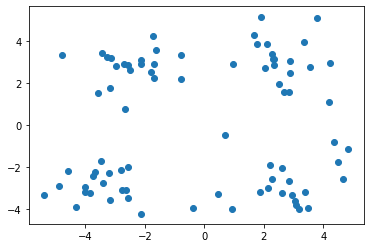

In [5]:
plt.scatter(data[:, 0], data[:, 1])

In [61]:
class KMeans:
    def __init__(self, k):
        self.k = k  # 质心数目
    
    def init_(self, X):
        X_max = np.max(X, axis=0)
        X_min = np.min(X, axis=0)
        m0 = np.zeros((self.k, X.shape[1]))
        for i in range(self.k):
            m_ = np.random.rand(X.shape[1]) * (X_max - X_min) + X_min
            m0[i] = m_
        return m0
      
    def fit(self, X):
        n_samples, n_features = X.shape
        # 保存聚类的结果, (所属类编号, 样本到所属类中心距离)
        cluster = np.zeros((n_samples, 2)) 
        # 初始化 中心
        m = self.init_(X)

        while True:
            cluster_last = cluster.copy()
            # 计算样本到各中心点距离, 指派到最近的点
            for i in range(n_samples):
                distance = np.sum(np.square(X[i] - m), axis=1)
                min_index = np.argmin(distance)
                cluster[i] = (min_index, distance[min_index])
            
            # 计算新的中心
            # print(m)
            for l in range(self.k):
                m[l] = np.mean(X[cluster[:, 0] == l,:], axis=0)
            if np.all(cluster[:, 0] == cluster_last[:, 0]):
                break
        return m, cluster

In [62]:
clf = KMeans(4)
m, cluster = clf.fit(data)

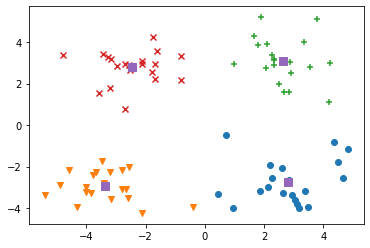

In [68]:
plt.scatter(data[cluster[:, 0]==0, 0], data[cluster[:, 0]== 0, 1], marker='o')
plt.scatter(data[cluster[:, 0]==1, 0], data[cluster[:, 0]== 1, 1], marker='v')
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='+')
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[:, 0], m[:, 1], marker='s', s=80)

In [69]:
SSE = np.sum(cluster[:, 1])
SSE

149.95430467642632

### 二分k-means算法
二分k-means算法是为了克服k-means算法收敛于局部最小值的问题,二分k-kmeans算法首先将所有点作为一个簇,然后将该簇一分为二.之后选择其中一个簇继续进行划分,选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE值.上述基于SSE的划分过程不断重复,直到得到用户指定的簇数目为止

二分k-means的伪代码形式如下:
* 将所有点看成一个簇
* 当簇数目小于 k 时
* 对于每一个簇
    * 计算总误差
    * 在给定的簇上面进行 KMeans 聚类（k=2）
    * 计算将该簇一分为二之后的总误差
* 选择使得误差最小的那个簇进行划分操作

另一种做法是选择 SSE 最大的簇进行划分，直到簇数目达到用户指定的数目位置。

In [74]:
a = np.arange(10)
b = a[np.newaxis, :]
np.append(a, np.arange(10), axis=0)

array([0, 1, 2, ..., 7, 8, 9])

In [ ]:
# 二分 K-Means 聚类算法
class BinMeans:
    def __init__(self, k):
        self.k = k
    
    def new_cluster(self, X, m_):
        
        
    def choose_best_cluster(self, cluster, m):
        # 选择最优的簇进行分类, 
        for l in range(len(m)):
            sse = np.sum(np.square(X[cluster[:, 0]==l, :] - m[l]))
            clf = KMeans(2)
            m, new_cluster = clf.fit(X[cluster[:, 0]==l, :])
            new_sse = np.sum(new_cluster[:, 1])
            
    def fit(self, X):
        n_samples, n_features = X.shape
        # 所有样本分到一个簇中
        m_ = np.mean(X, axis=0)
        m = [m_]
        cluster = np.zeros((n_samples, 2))
        cluster[:, 1] = np.sum(np.square(X[i] - m[0]), axis=1)
        
        while len(m) < self.k:
            max_sse = 0
            max_index = 0
            for l in range(len(m)):
                sse = 
                if sse > max_sse:
                    max_sse = sse
                    max_index = l
            # 对sse最大的簇进行 K-Means聚类(k=2)
            